In [9]:
from __future__ import division, print_function

# Std lib
import sys
import os

# hack to add project to path so we can import it without installing
biffpath = os.path.abspath("../")
if biffpath not in sys.path:
    sys.path.append(biffpath)

# Third-party
import gary.potential as gp
from gary.units import galactic
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.optimize as so

# Biff!
from biff import bfe

# Fit a spherical NFW potential with the BFE

In [10]:
spherical_nfw = gp.SphericalNFWPotential(v_c=1.E-6, r_s=1., units=galactic)

### First I just show that the 000 term in the BFE looks different from the NFW profile

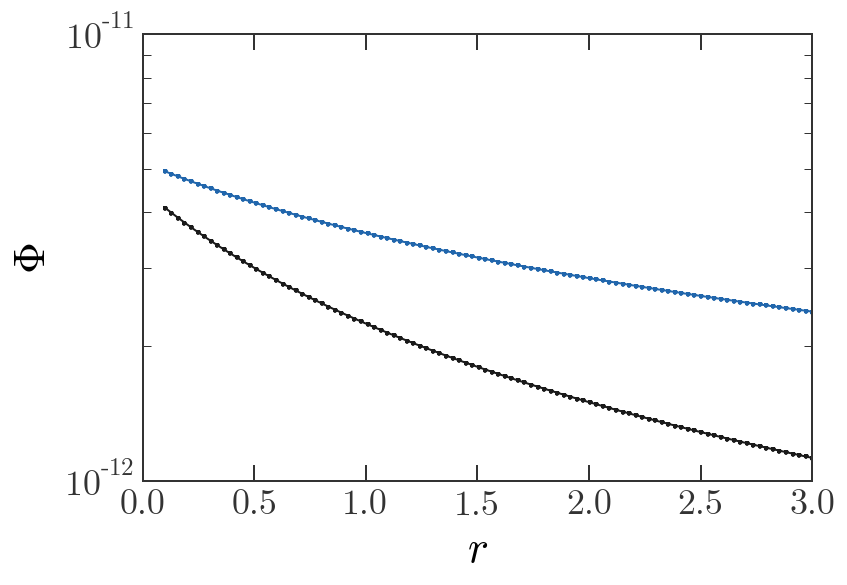

In [14]:
# first just check that they look order of magnitude the same...
nmax = 6
lmax = 0
sin_coeff = np.zeros((nmax+1,lmax+1,lmax+1))
cos_coeff = np.zeros((nmax+1,lmax+1,lmax+1))
cos_coeff[0,0,0] = -1.

xyz = np.zeros((100,3))
xyz[:,0] = np.linspace(0.1, 3., len(xyz))
bfe_pot = np.zeros(len(xyz))
bfe.value(xyz, bfe_pot, sin_coeff, cos_coeff, nmax, lmax)
bfe_pot *= spherical_nfw.G

plt.semilogy(xyz[:,0], np.abs(bfe_pot))
plt.semilogy(xyz[:,0], np.abs(spherical_nfw.value(xyz)))

plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi$')

### Now the actual fitting

In [15]:
nmax = 6
lmax = 0 # turn off the spherical harmonics

In [16]:
# evaluate the potential to fit on a grid of radii
xyz = np.zeros((100,3))
xyz[:,0] = np.linspace(0.1, 3., len(xyz))
spherical_nfw_vals = spherical_nfw.value(xyz)

In [24]:
def func1d(p):
    # the parameters in the fit are the coefficients
    #    (in this case, just the coefficients for the radial functions)
    sin_coeff = np.array(p[:len(p)//2]).reshape(nmax+1,1,1)
    cos_coeff = np.array(p[len(p)//2:]).reshape(nmax+1,1,1)
    
    # evaluate the BFE potential on the same grid as the potential to fit 
    bfe_pot = np.zeros(len(xyz))
    bfe.value(xyz, bfe_pot, sin_coeff, cos_coeff, nmax, lmax)
    bfe_pot *= spherical_nfw.G # units hack...
    
    # shhh, this is dumb
    V = np.sum(((spherical_nfw_vals - bfe_pot)/spherical_nfw_vals)**2)
    return V # minimize this
#     return -V # maximize this

In [25]:
# initial value for coefficients: just turn on one cosine term
x0 = np.append(np.zeros(nmax+1), np.zeros(nmax+1))
x0[nmax+1] = -0.1
res = so.minimize(func1d, x0=x0)
print(res.success)
print(res.x)

True
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.70865674e+00
  -3.02860397e-01  -9.93425365e-02  -3.62078490e-02  -1.27651326e-02
  -3.72286674e-03  -8.15780407e-04]


Hm, all the sin terms are 0...but look, coefficients for the cosine terms!

### Now plot the BFE profile and the NFW profile

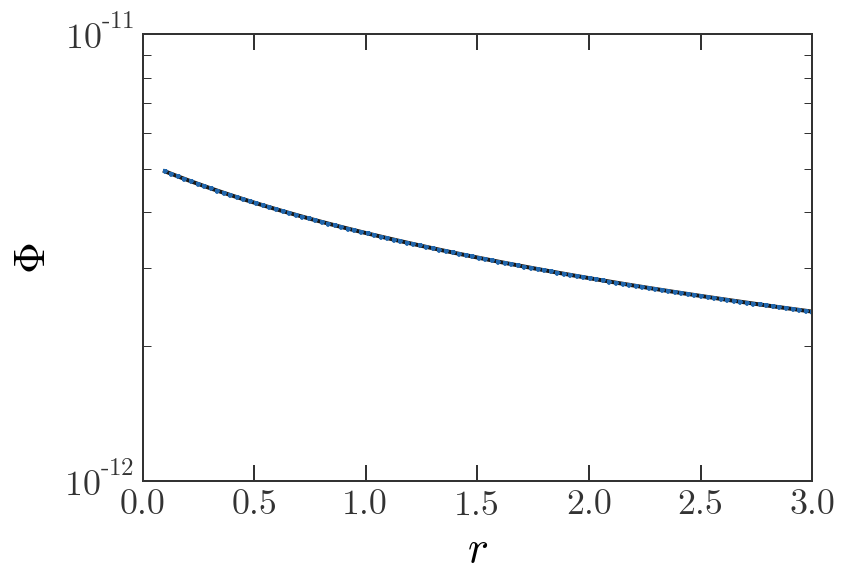

In [29]:
p = res.x
sin_coeff = np.array(p[:len(p)//2]).reshape(nmax+1,1,1)
cos_coeff = np.array(p[len(p)//2:]).reshape(nmax+1,1,1)

bfe_pot = np.zeros(len(xyz))
bfe.value(xyz, bfe_pot, sin_coeff, cos_coeff, nmax, lmax)
bfe_pot *= spherical_nfw.G

plt.semilogy(xyz[:,0], np.abs(spherical_nfw.value(xyz)), marker=None, lw=2.)
plt.semilogy(xyz[:,0], np.abs(bfe_pot), linestyle='none', marker='.')

plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi$')

Exxxxcellent - they sit on top of one another.

# Fit a flattened (axisymmetric) NFW potential with the BFE

In [30]:
flat_nfw = gp.LeeSutoTriaxialNFWPotential(v_c=1.E-6, r_s=1., 
                                          a=1., b=1., c=0.8,
                                          units=galactic)

In [31]:
nmax = 4
lmax = 2

Now we need to fit to a 2D grid of values

In [33]:
grid = np.meshgrid(np.linspace(-3,3,100), np.linspace(-3,3,100))
grid_shape = grid[0].shape
x1,x2 = map(np.ravel, grid)

xyz = np.zeros((len(x1),3))
xyz[:,0] = x1
xyz[:,2] = x2
flat_nfw_vals = flat_nfw.value(xyz)

In [34]:
def func2d(p):
    sin_coeff = np.array(p[:len(p)//2]).reshape(nmax+1,lmax+1,lmax+1)
    cos_coeff = np.array(p[len(p)//2:]).reshape(nmax+1,lmax+1,lmax+1)
    
    bfe_pot = np.zeros(len(xyz))
    bfe.value(xyz, bfe_pot, sin_coeff, cos_coeff, nmax, lmax)
    bfe_pot *= flat_nfw.G
    V = np.sum(((flat_nfw_vals - bfe_pot)/flat_nfw_vals)**2)
    return V # minimize this
#     return -V # maximize this

In [35]:
x0 = np.append(np.ravel(np.zeros((nmax+1,lmax+1,lmax+1))), 
               np.ravel(np.zeros((nmax+1,lmax+1,lmax+1))))
x0[len(x0)//2] = -2. # again, start with just the first cosine term on
res = so.minimize(func2d, x0=x0)
print(res.success)

True


### Now I'll plot the residuals $\Phi_{\rm BFE} - \Phi_{\rm NFW}$

In [36]:
p = res.x
sin_coeff = np.array(p[:len(p)//2]).reshape(nmax+1,lmax+1,lmax+1)
cos_coeff = np.array(p[len(p)//2:]).reshape(nmax+1,lmax+1,lmax+1)

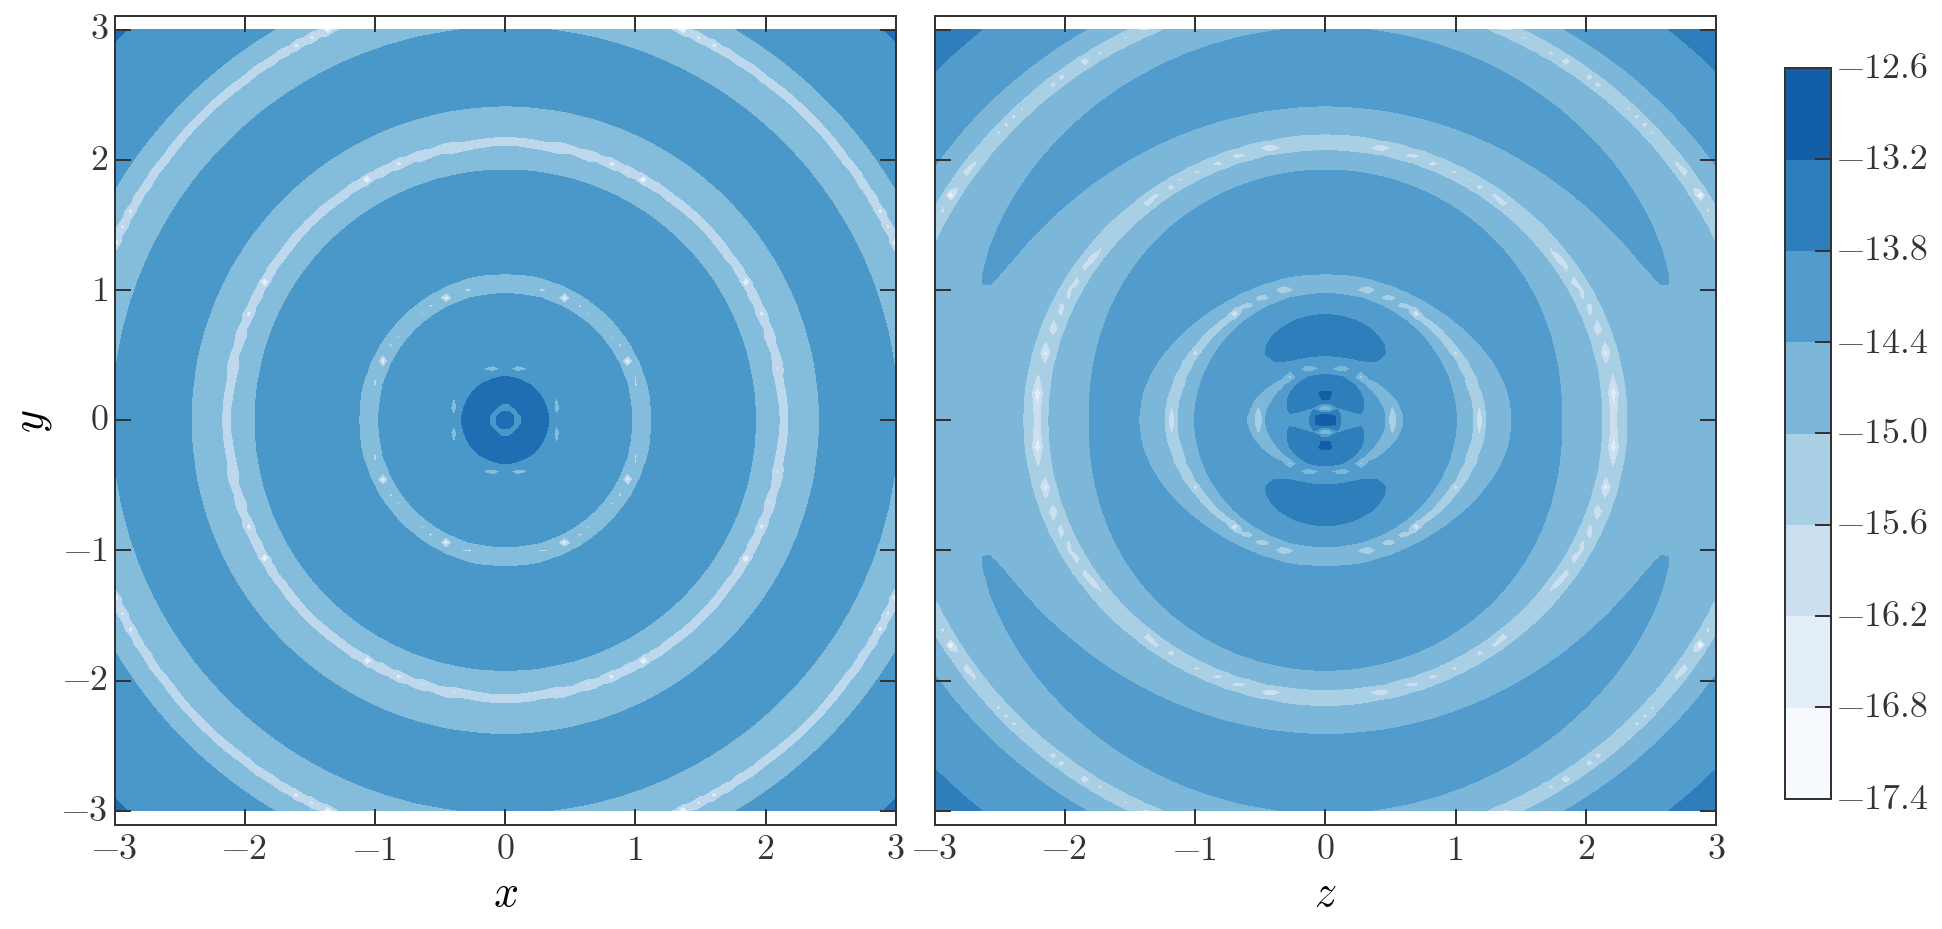

In [59]:
fig,axes = plt.subplots(1,2,figsize=(16,7.25), sharex=True, sharey=True)

# x-y
xyz = np.zeros((len(x1),3))
xyz[:,0] = x1
xyz[:,1] = x2
val = np.zeros(len(xyz))
bfe.value(xyz, val, sin_coeff, cos_coeff, nmax, lmax)
val *= flat_nfw.G
val -= flat_nfw.value(xyz)
ax = axes[0]
ax.contourf(x1.reshape(grid_shape), 
            x2.reshape(grid_shape), 
            np.log10(np.abs(val.reshape(grid_shape))), 
            cmap='Blues', vmin=-17, vmax=-12.)
ax.set_aspect('equal')
ax.set_xlim(x1.min(), x1.max())
ax.set_ylim(*ax.get_xlim())

# z-y
xyz = np.zeros((len(x1),3))
xyz[:,2] = x1
xyz[:,1] = x2
val = np.zeros(len(xyz))
bfe.value(xyz, val, sin_coeff, cos_coeff, nmax, lmax)
val *= flat_nfw.G
val -= flat_nfw.value(xyz)
ax = axes[1]
c = ax.contourf(x1.reshape(grid_shape), 
                x2.reshape(grid_shape), 
                np.log10(np.abs(val.reshape(grid_shape))), 
                cmap='Blues', vmin=-17, vmax=-12.)
ax.set_aspect('equal')

fig.subplots_adjust(wspace=0.05, right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cbar_ax)

axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")
axes[1].set_xlabel("$z$")

Residuals are plotted in log, so they are less than $10^{-12}$. Cool.